# Maximum likelihood estimator for contribution of different species

## Imports and initizializations:

In [ ]:
import csv
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from BamFileUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas"
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas"
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas"
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "mpieva-nuclear_sediment_pipeline-624f568/metagen_utils/data/substitution_matrix.tsv"

In [7]:
number_of_sapienses = 50
number_of_neanderthals = 50
number_of_denisovans = 50

total_length = number_of_sapienses + number_of_neanderthals + number_of_denisovans
all_indexes = [i for i in range(total_length)]
neanderthal_indexes = [i for i in all_indexes if i<number_of_neanderthals]
sapienses_indexes = [i for i in all_indexes if i>= number_of_neanderthals and i < number_of_sapienses + number_of_neanderthals]
denisovans_indexes = [i for i in all_indexes if i>= number_of_sapienses + number_of_neanderthals]

simulated_reads = neanderthals_500_generated[:number_of_neanderthals] + sapiens_500_generated[300:300+number_of_sapienses] + denisovan_500_samples[:number_of_denisovans]

In [8]:
list_of_reads_only_ancient = getListOfReadsFromBamFile("data/A27417.Homo_sapiens.uniq.L35MQ25.deam3or5.bam")

[E::idx_find_and_load] Could not retrieve index file for 'data/A27417.Homo_sapiens.uniq.L35MQ25.deam3or5.bam'


## Load references file names for all species

In [10]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

## Creating a maximum likelihood estimator - to estimate the contribution of each species to the data set:

In [14]:
likeli_calculator = ExplainableMaximumLikelihoodCalculator(simulated_reads[:10],
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  10
start working on read number 0


## Estimation to the contribution of each species to the data set:

In [15]:
total_number_of_reads = likeli_calculator.number_of_reads
estimation = likeli_calculator.estimate_species_proportions(100)
actual_values = {'Homo Sapiens' : number_of_sapienses / total_number_of_reads, 'Neanderthals' : number_of_neanderthals / total_number_of_reads, 'Denisovans':number_of_denisovans / total_number_of_reads}
comparison = estimation.append(actual_values, ignore_index=True).rename(index={0: "Estimation", 1: "Actual"})

print(f"sample size: {total_length}")

comparison


sample size: 150


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.0,1.0,0.0
Actual,5.0,5.0,5.0


## Results basic explanation:

In [38]:
likeli_calculator.explain_the_results()

sapien    neanderthel      denisovan     Read number
These are reads that are probably Sapien:

((1.2209573485947873e-06, 8.140919254940325e-07, 1.2387945125425846e-10), 17)
((0.0026213867430714094, 0.0017488514033706431, 6.071593648459943e-07), 25)
((0.009581629530097507, 1.3819210966607596e-05, 1.3758636558283813e-10), 50)
((0.001052008908439411, 4.3551004012637843e-07, 1.287953730377672e-10), 52)
((0.008578203922660066, 1.9665994301557204e-06, 1.9665994301557204e-06), 53)
((0.2157284767616223, 0.17978436369595419, 3.9280786201090914e-05), 56)
((0.429821864493534, 8.69512688259212e-08, 0.00016907586083177235), 57)
((1.3896483062214625e-09, 1.165837545670889e-09, 2.5654809906815928e-20), 58)
((8.100838819588735e-06, 2.3956980587290076e-09, 2.3956980587290076e-09), 59)
((7.357381587630212e-07, 1.0611264816900242e-09, 4.904931571801775e-07), 64)
((0.008532914087287754, 2.52347765083104e-06, 1.0763299481376294e-12), 67)
((3.19996170715644e-07, 4.944250066134558e-12, 1.6294819443004175e-1

In [39]:
likeli_calculator.getGeneralStatistics()

Average read length: 67.24
Allele frequencies in the data:


,frequency
T,0.266508
C,0.292683
G,0.127305
A,0.313504
TT,0.058199
TC,0.069403
TG,0.033710
TA,0.089728
CT,0.085168
CC,0.072576


## Calculate shapley values for every read and visualize it:

In [40]:
shaps = likeli_calculator.calculate_shap_values(5000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [41]:
data = likeli_calculator.generateCounterFactualMinimalSetToRemoveAndChangeMax(shaps)

Change dominating species from Neanderthal to Denisovan would require removing 2 reads: [10, 39]


summary plot:


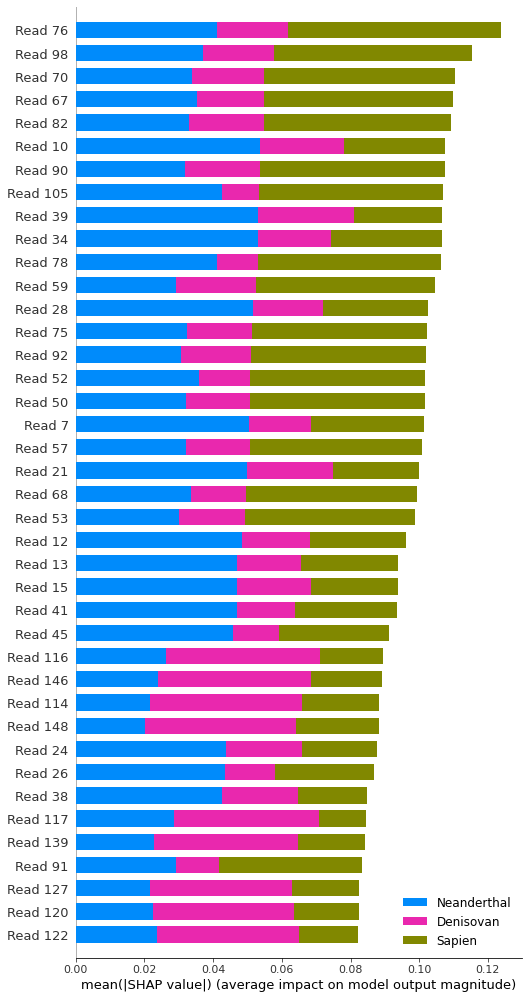

Force plots
Homo Sapiens:


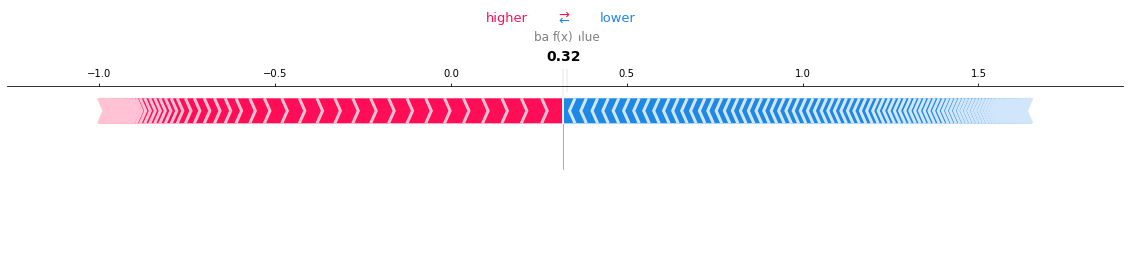

Neanderthals:


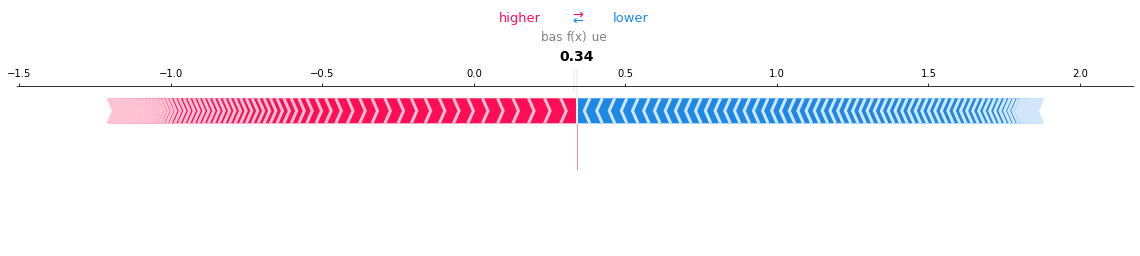

Denisovans:


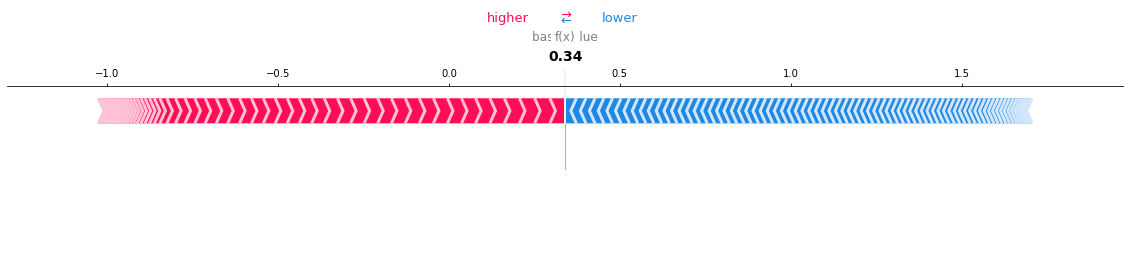

Decision plots:
Homo Sapiens


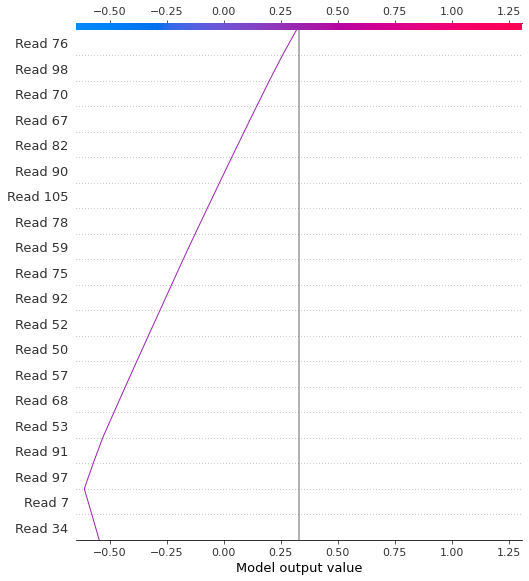

Neanderthals:


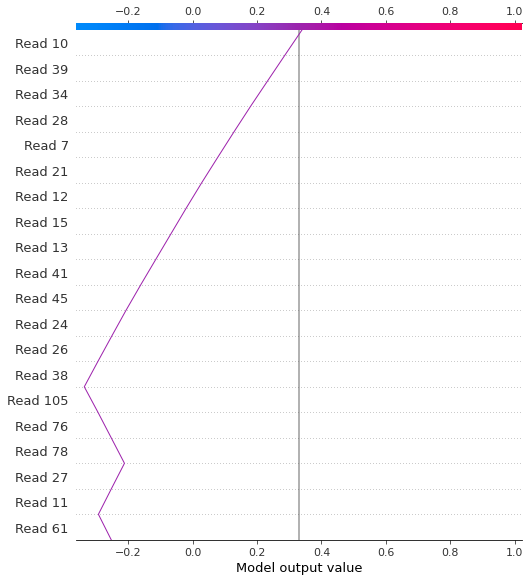

Denisovans:


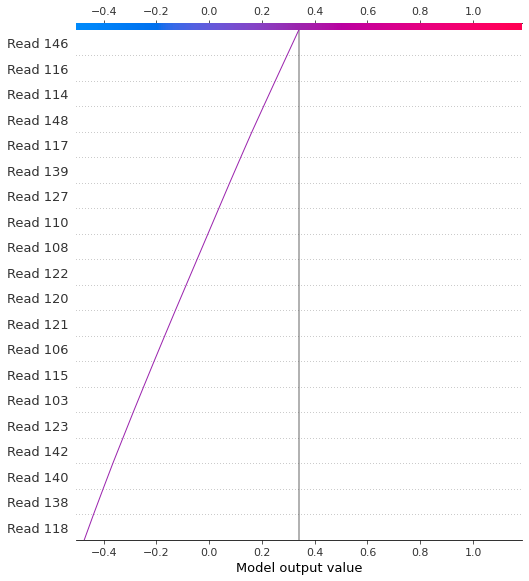

Multi output decision plot:


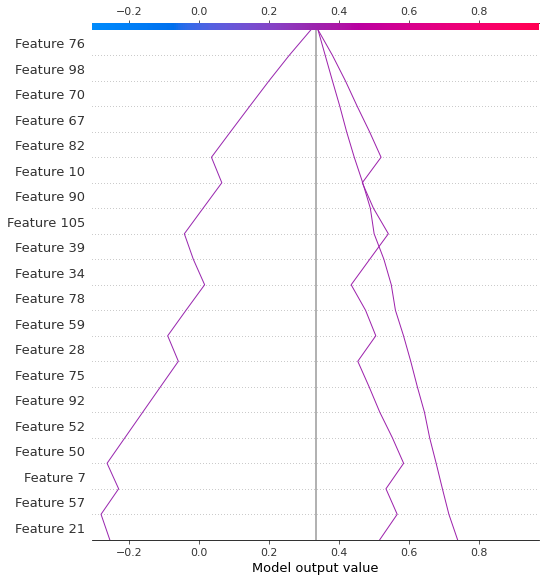

In [42]:
likeli_calculator.plot_shap_values(shaps)

AttributeError: module 'matplotlib.pyplot' has no attribute 'spines'

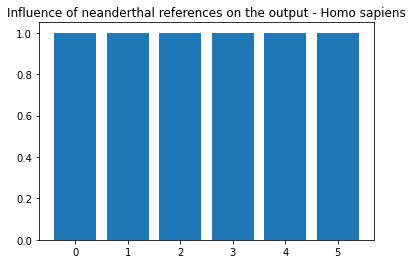

In [24]:
influence_values = []
plt.bar([i for i in range(len(neanderthals_reference_file_names))],[1 for b in range(len(neanderthals_reference_file_names))])
plt.title("Influence of neanderthal references on the output - Homo sapiens")
plt.spines['top'].set_visible(False)
plt.spines['right'].set_visible(False)
plt.spines['left'].set_visible(False)
plt.show()

plt.bar([i for i in range(len(neanderthals_reference_file_names))],[b[1] for b in influence_values])
plt.title("Influence of neanderthal references on the output - Neanderthals")
plt.show()

plt.bar([i for i in range(len(neanderthals_reference_file_names))],[b[2] for b in influence_values])
plt.title("Influence of neanderthal references on the output - Denisovan")
plt.show()

### Summary plot

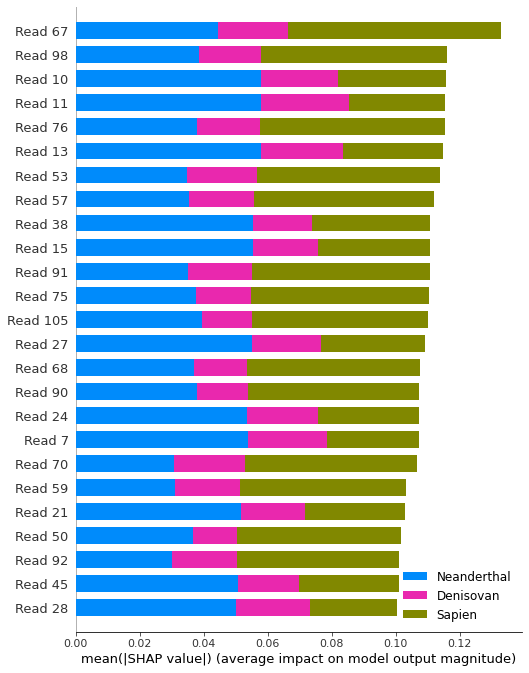

In [10]:
sample = np.ones((1,likeli_calculator.number_of_reads))
shap.initjs()
shap.summary_plot(shap_values=shaps,
                features=sample,
                plot_type="bar",
                class_names = ["Sapien", "Neanderthal", "Denisovan"],
                feature_names = ["Read " + str(i) for i in range(likeli_calculator.number_of_reads)],
                max_display=25,
                )

### Force plots:

In [11]:
shap.force_plot(likeli_calculator.explainer.expected_value[0], shaps[0], feature_names=["Read " + str(i) for i in range(likeli_calculator.number_of_reads)])


In [12]:
print("Neanderthals")
shap.force_plot(likeli_calculator.explainer.expected_value[1], shaps[1], feature_names=["Read " + str(i) for i in range(likeli_calculator.number_of_reads)])

Neanderthals


In [13]:
print("Denisovans")
shap.force_plot(likeli_calculator.explainer.expected_value[2], shaps[2], feature_names=["Read " + str(i) for i in range(likeli_calculator.number_of_reads)])

Denisovans


### Decision plots:

Sapienses:


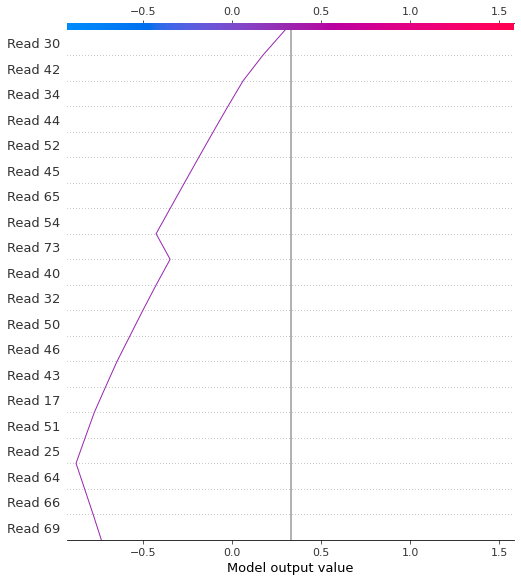

In [37]:
print("Sapienses:")
shap.decision_plot(likeli_calculator.explainer.expected_value[0], shaps[0], feature_names=["Read " + str(i) for i in range(likeli_calculator.number_of_reads)])


Neanderthals:


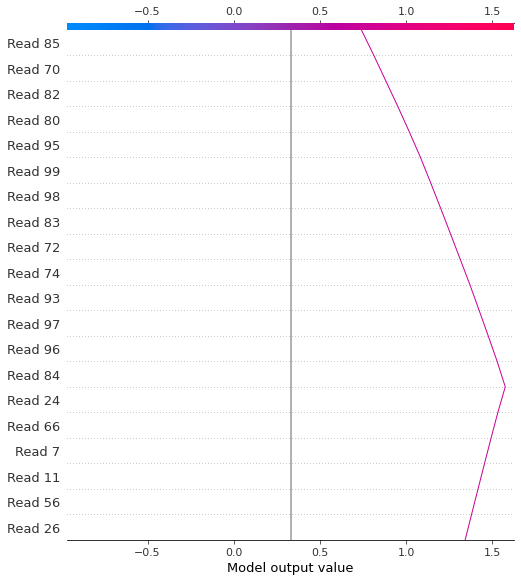

In [89]:
print("Neanderthals:")
shap.decision_plot(likeli_calculator.explainer.expected_value[1], shaps[1], feature_names=["Read " + str(i) for i in range(likeli_calculator.number_of_reads)])

Denisovans:


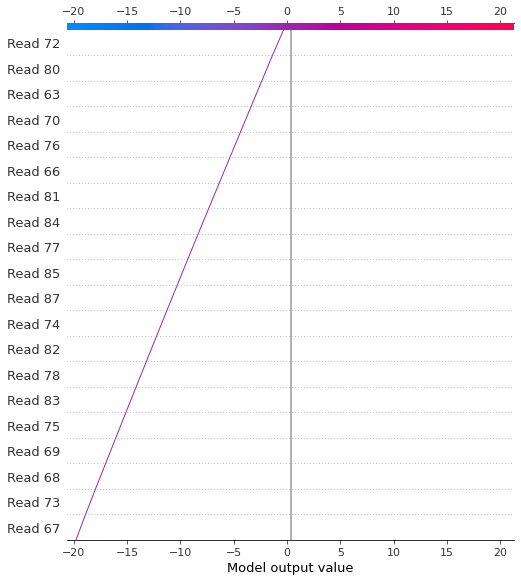

In [69]:
print("Denisovans:")
shap.decision_plot(likeli_calculator.explainer.expected_value[2], shap_estimation[2], feature_names=["Read " + str(i) for i in range(likeli_calculator.number_of_reads)])

Multi output decision plot:


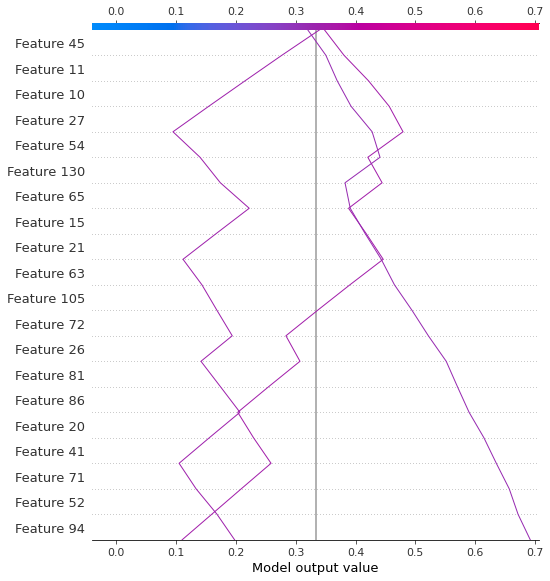

In [27]:
print("Multi output decision plot:")
shap.multioutput_decision_plot(list(likeli_calculator.explainer.expected_value), shaps, row_index=0)

In [21]:
likeli_calculator.plot_alignments_of_read(78)

Printing all alignments for read number 78:
Read length is 84:
Alignments to sapienses:
Sapiens-AF346981.1
101 ACTCTGTTCGCAGCAGTCTGCGCCCTTACACAAAATGACATCAAAAAAATCGTAGCCTTCTCCACTTCAAGTCAACTAGGACTC
    ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
  1 ACTCTGTTCGCAGCAGTCTGCGCCCTTACACAAAATGACATCAAAAAAATCGTAGCCTTCTCCACTTCAAGTCAACTAGGACTC
  Score=84

Sapiens-AY195760.2
98 ACTCTGTTCGCAGCAGTCTGCGCCCTTACACAAAATGACATCAAAAAAATCGTAGCCTTCTCCACTTCAAGTCAACTAGGACTC
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 1 ACTCTGTTCGCAGCAGTCTGCGCCCTTACACAAAATGACATCAAAAAAATCGTAGCCTTCTCCACTTCAAGTCAACTAGGACTC
  Score=84

Sapiens-AY882416.1
99 ACTCTGTTCGCAGCAGTCTGCGCCCTTACACAAAATGACATCAAAAAAATCGTAGCCTTCTCCACTTCAAGTCAACTAGGACTC
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
 1 ACTCTGTTCGCAGCAGTCTGCGCCCTTACACAAAATGACATCAAAAAAATCGTAGCCTTCTCCACTTCAAGTCAACTAGGACTC
  Score=84

Sapiens-AY963586.3
110 A

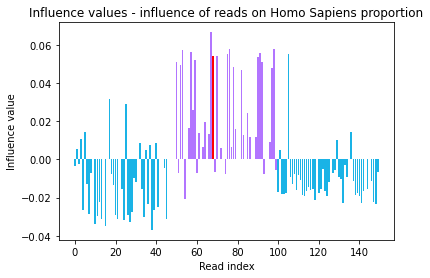

In [39]:
color = [(0.1,0.7,0.9)]*50 + [(0.5,0.1,1,0.6)]*50+[(0.1,0.7,0.9)]*50
color[68] = 'red'
plt.bar([i for i in range(150)],shaps[0][0],color=color)
plt.title("Influence values - influence of reads on Homo Sapiens proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.savefig("influence_values_of_homo_sapienses")

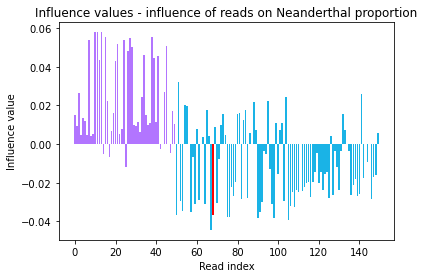

In [40]:
color = [(0.5, 0.1, 1, 0.6)]*50 + [(0.1,0.7,0.9)]*100
color[68] = 'red'
plt.bar([i for i in range(150)],shaps[1][0],  color=color)
plt.title("Influence values - influence of reads on Neanderthal proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.savefig("influence_values_of_Neanderthals")

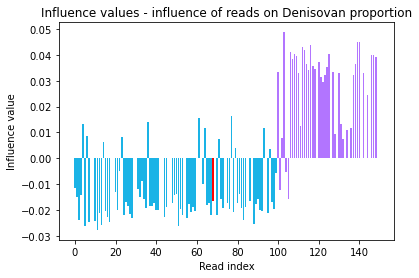

In [41]:
color = [(0.1,0.7,0.9)]*100+[(0.5,0.1,1,0.6)]*50
color[68] = 'red'
plt.bar([i for i in range(150)],shaps[2][0],color=color)
plt.title("Influence values - influence of reads on Denisovan proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.savefig("influence_values_of_denisovans")
plt.show()


### Get most influencing reads:

In [35]:
likeli_calculator.getMostInfluencingReads(shaps, 5)

Most influencing reads for sapiens (and impact):
[(84, 0.05908891022655433), (72, 0.05698471000910947), (82, 0.05629094302102936), (71, 0.05393197862453492), (74, 0.0510566699142905)]
Most influencing reads for neanderthals (and impact):
[(28, 0.06404318907392578), (51, 0.05991540300882063), (26, 0.05386225125105924), (13, 0.05258402777217657), (45, 0.05184903195136792)]
Most influencing reads for denisovans (and impact):
[(148, 0.04832455164540726), (113, 0.04701850645540292), (103, 0.043772595579768), (138, 0.04366976347597885), (112, 0.042849819247732755)]


[[(84, 0.05908891022655433),
  (72, 0.05698471000910947),
  (82, 0.05629094302102936),
  (71, 0.05393197862453492),
  (74, 0.0510566699142905)],
 [(28, 0.06404318907392578),
  (51, 0.05991540300882063),
  (26, 0.05386225125105924),
  (13, 0.05258402777217657),
  (45, 0.05184903195136792)],
 [(148, 0.04832455164540726),
  (113, 0.04701850645540292),
  (103, 0.043772595579768),
  (138, 0.04366976347597885),
  (112, 0.042849819247732755)]]

## Estimate the accuracy of the model:
Here we sample groups from the known simulated samples we created, and calculate how accurate the model is on the sample using Chi Squared test

In [19]:
def get_guess(size_of_sample, indexes_to_consider):
    sample = random.sample(indexes_to_consider, size_of_sample)
    neanderthals_in_sample = len([i for i in sample if i in neanderthal_indexes])/size_of_sample
    sapiens_in_sample = len([i for i in sample if i in sapienses_indexes])/size_of_sample
    denisovans_in_sample = len([i for i in sample if i in denisovans_indexes])/size_of_sample
    guess = np.asarray([sapiens_in_sample, neanderthals_in_sample, denisovans_in_sample])
    return guess
 

In [65]:
sample_sizes = [10*i for i in range(100) if i > 0 and 10*i < total_length]
print(sample_sizes)
indexes = [i for i in range(total_length)]
number_of_trials_per_sample_size = 100

data_kl = []
data_kl_guess = []

for sample_size in sample_sizes:
    print(sample_size)
    chi_square_p_values_current = []
    number_of_samples = 0
    while (number_of_samples < number_of_trials_per_sample_size):
        sample = random.sample(indexes, sample_size)
        neanderthals_in_sample = len([i for i in sample if i in neanderthal_indexes])/sample_size
        sapiens_in_sample = len([i for i in sample if i in sapienses_indexes])/sample_size
        denisovans_in_sample = len([i for i in sample if i in denisovans_indexes])/sample_size
        if(denisovans_in_sample > 0 and sapiens_in_sample > 0 and neanderthals_in_sample > 0):
            expected_result = np.asarray([sapiens_in_sample, neanderthals_in_sample, denisovans_in_sample])
            print(expected_result)
            result = likeli_calculator.calc_maximum_likelihood_on_subset(sample).values[0]
            result_of_guess = get_guess(sample_size, indexes)
            kl_divergence_result = sum(rel_entr(result, expected_result))
            kl_divergence_guess = sum(rel_entr(result_of_guess, expected_result))
            data_kl.append((sample_size, kl_divergence_result))
            data_kl_guess.append((sample_size, kl_divergence_guess))
            number_of_samples+=1


[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
10
[0.2 0.4 0.4]
[0.2 0.1 0.7]
[0.3 0.3 0.4]
[0.2 0.3 0.5]
[0.2 0.4 0.4]
[0.3 0.2 0.5]
[0.1 0.4 0.5]
[0.1 0.6 0.3]
[0.1 0.3 0.6]
[0.3 0.2 0.5]
[0.1 0.4 0.5]
[0.3 0.3 0.4]
[0.1 0.6 0.3]
[0.1 0.4 0.5]
[0.2 0.7 0.1]
[0.4 0.2 0.4]
[0.3 0.3 0.4]
[0.1 0.7 0.2]
[0.2 0.2 0.6]
[0.2 0.5 0.3]
[0.1 0.3 0.6]
[0.1 0.3 0.6]
[0.1 0.5 0.4]
[0.3 0.3 0.4]
[0.2 0.3 0.5]
[0.1 0.6 0.3]
[0.4 0.3 0.3]
[0.4 0.3 0.3]
[0.3 0.4 0.3]
[0.2 0.4 0.4]
[0.3 0.5 0.2]
[0.3 0.4 0.3]
[0.3 0.2 0.5]
[0.3 0.2 0.5]
[0.5 0.1 0.4]
[0.3 0.5 0.2]
[0.5 0.3 0.2]
[0.2 0.5 0.3]
[0.2 0.4 0.4]
[0.4 0.4 0.2]
[0.5 0.2 0.3]
[0.4 0.5 0.1]
[0.2 0.4 0.4]
[0.2 0.4 0.4]
[0.3 0.3 0.4]
[0.2 0.7 0.1]
[0.1 0.8 0.1]
[0.4 0.2 0.4]
[0.5 0.3 0.2]
[0.3 0.2 0.5]
[0.2 0.4 0.4]
[0.1 0.6 0.3]
[0.4 0.4 0.2]
[0.2 0.6 0.2]
[0.1 0.4 0.5]
[0.1 0.4 0.5]
[0.3 0.5 0.2]
[0.3 0.3 0.4]
[0.3 0.3 0.4]
[0.3 0.2 0.5]
[0.2 0.6 0.2]
[0.2 0.5 0.3]
[0.3 0.3 0.4]
[0.2 0.4 0.4]
[0.3 0.4 0.3]
[0.4 0.3 0.3]
[0.1 0.7 0.

KeyboardInterrupt: 

In [ ]:
indexes = [i for i in range(total_length)]

data_kl = []
data_kl_guess = []

for i in range(1000):
    if (i%50==0):
        print(i)
    neanderthal_sample_size = random.randint(1,len(neanderthal_indexes))
    sapien_sample_size = random.randint(1,len(sapienses_indexes))
    denisovan_sample_size = random.randint(1,len(denisovans_indexes))
    neanderthal_sample = random.sample(neanderthal_indexes, neanderthal_sample_size)
    sapien_sample = random.sample(sapienses_indexes, sapien_sample_size)
    denisovan_sample = random.sample(denisovans_indexes, denisovan_sample_size)
    sample = neanderthal_sample + sapien_sample + denisovan_sample
    sample_size = len(sample)
    neanderthals_in_sample = neanderthal_sample_size/sample_size
    sapiens_in_sample = sapien_sample_size/sample_size
    denisovans_in_sample = denisovan_sample_size/sample_size
    expected_result = np.asarray([sapiens_in_sample, neanderthals_in_sample, denisovans_in_sample])
    result = likeli_calculator.calc_maximum_likelihood_on_subset(sample).values[0]
    result_of_guess = get_guess(sample_size, indexes)
    kl_divergence_result = sum(rel_entr(result, expected_result))
    kl_divergence_guess = sum(rel_entr(result_of_guess, expected_result))
    data_kl.append(((sample_size // 10 * 10), kl_divergence_result))
    data_kl_guess.append(((sample_size // 10 * 10), kl_divergence_guess))
    number_of_samples+=1
    


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


<AxesSubplot:xlabel='Number Of Reads', ylabel='KL_divergence'>

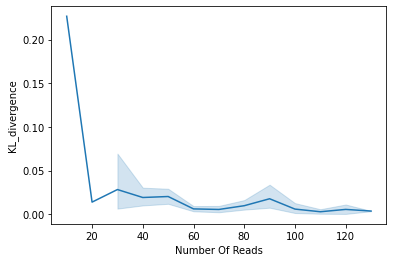

In [60]:
df_kl_divergence = pd.DataFrame(data_kl, columns=["Number Of Reads", "KL_divergence"])
sns.lineplot(data=df_kl_divergence, x="Number Of Reads", y="KL_divergence")


<AxesSubplot:xlabel='Number Of Reads', ylabel='KL_divergence'>

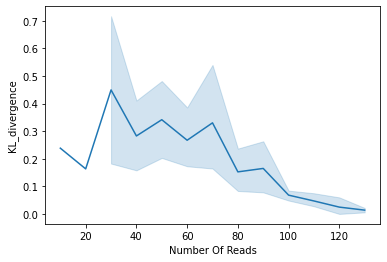

In [61]:
df_kl_divergence_guess = pd.DataFrame(data_kl_guess, columns=["Number Of Reads", "KL_divergence"])
sns.lineplot(data=df_kl_divergence_guess, x="Number Of Reads", y="KL_divergence")

## Plot alignments of single read:

In [26]:
likeli_calculator.plot_alignments_of_read(7)

Printing all alignments for read number 7:
Read length is 78:
Alignments to sapienses:
Sapiens-AF346981.1
101 AAAACCCGCCACATCTACCATCACCCTCTACATCACCGCCCCGACCTTAGCTCTCACCATCGCTCTTCTACTATGAAC
    |||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||
  1 AAAACCCGCCACATCCACCATCACCCTCTACATCACCGCCCCGACCTTAGCTCTCACCATCGCTTTTCTACTATGAAC
  Score=76.2

Sapiens-AY195760.2
98 AAAACCCGCCACATCTACCATCACCCTCTACATCACCGCCCCGACCTTAGCTCTCACCATCGCTCTTCTACTATGAAC
   |||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||
 1 AAAACCCGCCACATCCACCATCACCCTCTACATCACCGCCCCGACCTTAGCTCTCACCATCGCTTTTCTACTATGAAC
  Score=76.2

Sapiens-AY882416.1
99 AAAACCCGCCACATCTACCATCACCCTCTACATCACCGCCCCGACCTTAGCTCTCACCATCGCTCTTCTACTATGAAC
   |||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||.|||||||||||||
 1 AAAACCCGCCACATCCACCATCACCCTCTACATCACCGCCCCGACCTTAGCTCTCACCATCGCTTTTCTACTATGAAC
  Score=76.2

Sapiens-AY963586.3
110 AAAACCCGCCACATCTACCATCACCCTCTACATCACCGCCCCGACCTTAG

## Influence values - sample with and without

In [9]:
a = likeli_calculator.influenceOfReferenceNeanderthal(4)

0.18630272458130442
0.024440833852446456
0.00022136474263820195
0.0018690486859444654
0.00980137277587816
0.08829427926569083
0.28228921009007113
0.0022146650794865196
0.018311634123397348
0.013631858238521944
0.43149718133295833
0.007670131169280389
0.17644577652841592
1.1330694000330753e-05
0.0005685331877311381
0.003271590075926422
0.0033503827235208394
7.327188408738815e-07
0.10944767517299006
0.00015200647609324073
1.3819210966607594e-05
0.0015976380829865924
4.355100401263784e-07
1.96659943015572e-06
0.1518596181767337
0.4902773669143016
0.17259554108282055
1.0434082344620724e-07
1.1210753935607745e-09
2.395698058729007e-09
0.1646976888318245
0.00016489659336479246
0.0052683493273034294
0.0002858625562616677
1.0611264816900244e-09
0.007697915388806461
1.4673955206415845e-05
2.5234776508310398e-06
4.944250066134557e-12
0.0980136050592125
9.624562370410742e-07
0.0009351513296732823
0.2631228273478453
1.2960445159224816e-12
0.012170318782511829
8.33642540585931e-11
0.000582942561173

In [11]:
l = []
for i in range(likeli_calculator.number_of_neanderthal_references):
    l.append(likeli_calculator.influenceOfReferenceNeanderthal(i,100))

0.18630272458130442
0.024440833852446456
0.00022136474263820195
0.0018690486859444654
0.00980137277587816
0.08829427926569083
0.28228921009007113
0.0033216610561363955
0.018311634123397348
0.013631858238521944
0.43149718133295833
0.007670131169280389
0.17644577652841592
1.1330694000330753e-05
0.0005685331877311381
0.004906142343948874
0.0033503827235208394
9.768380947343344e-07
0.10944767517299006
0.00015200647609324073
1.3819210966607594e-05
0.0015976542874656572
4.355100401263784e-07
1.96659943015572e-06
0.1518596181767337
0.4902773669143016
0.21572847676162232
5.3035442363882515e-08
1.1210753935607745e-09
2.395698058729007e-09
0.1646976888318245
0.00016489659336479246
0.0052683493273034294
0.0002858625562616677
1.0611264816900244e-09
0.007697915388806461
1.4673955206415845e-05
2.5234776508310398e-06
4.944250066134557e-12
0.0980136050592125
9.624562370410742e-07
0.0009351513296732823
0.2631228273478453
1.619932516912741e-12
0.012170318782511829
8.33642540585931e-11
0.0005829425611738

In [13]:
l

[array([ 0.0036, -0.0058,  0.0022]),
 array([-0.0106,  0.0182, -0.0076]),
 array([-0.0046,  0.004 ,  0.0006]),
 array([-0.0022,  0.0012,  0.001 ]),
 array([ 0.0006, -0.0012,  0.0006]),
 array([-0.0002, -0.0008,  0.001 ])]

In [39]:
(shap_estimation_scaled, shap_estimation_not_scaled) = likeli_calculator.estimate_shapley_values(100)

Start working on read number 0 in processId 429
Start working on read number 1 in processId 430
Start working on read number 2 in processId 431
Start working on read number 3 in processId 432
Start working on read number 4 in processId 433
Start working on read number 5 in processId 434
Start working on read number 6 in processId 435
Start working on read number 7 in processId 436
Start working on read number 8 in processId 437
Start working on read number 9 in processId 438
Start working on read number 10 in processId 439
Start working on read number 11 in processId 440
Start working on read number 12 in processId 441
Start working on read number 13 in processId 442
Start working on read number 14 in processId 443
Start working on read number 15 in processId 444
Start working on read number 16 in processId 442
Start working on read number 17 in processId 439
Start working on read number 18 in processId 432
Start working on read number 19 in processId 429
Start working on read number 2

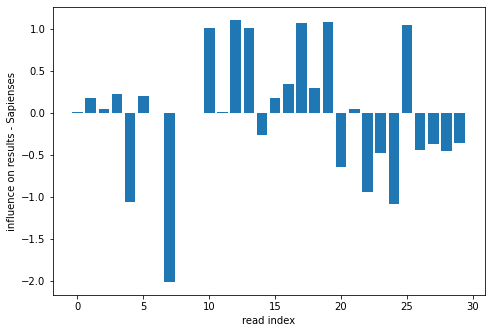

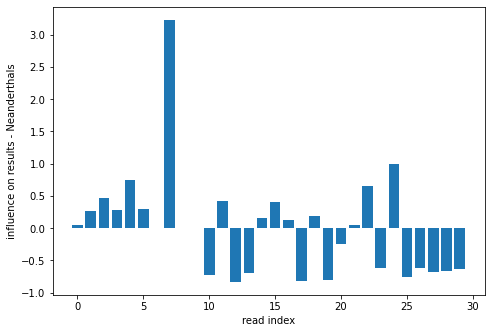

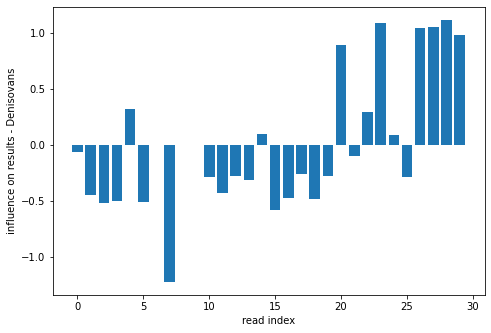

In [9]:
likeli_calculator.plot_influence_values(shap_estimation_scaled)

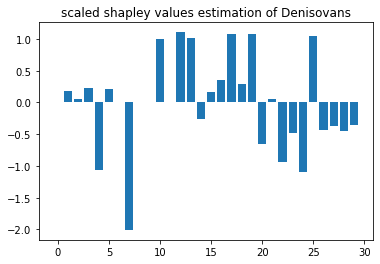

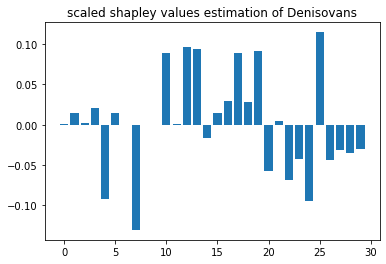

In [12]:
plt.bar([i for i in range(30)],shap_estimation_scaled[0][0])
plt.title("scaled shapley values estimation of Denisovans")
plt.savefig("shapley_estimation_denisovans")
plt.show()

plt.bar([i for i in range(30)],shap_estimation_not_scaled[0][0])
plt.title("scaled shapley values estimation of Denisovans")
plt.savefig("shapley_estimation_denisovans")
plt.show()




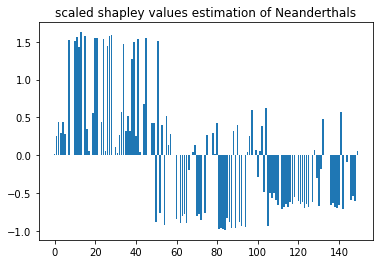

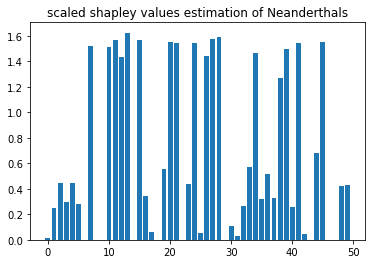

In [72]:
plt.bar([i for i in range(150)],shap_estimation[1][0])
plt.title("scaled shapley values estimation of Neanderthals")
plt.savefig("shapley_estimation_neanderthals_all")
plt.show()

plt.bar([i for i in range(50)],shap_estimation[1][0][:50])
plt.title("scaled shapley values estimation of Neanderthals")
plt.savefig("shapley_estimation_neanderthals_first_50")
plt.show()

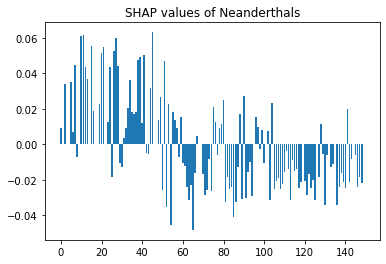

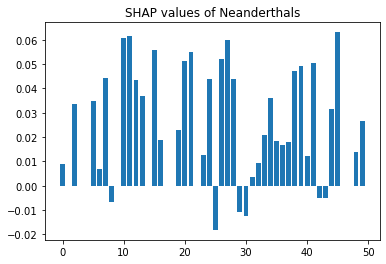

In [74]:
plt.bar([i for i in range(150)],shaps[1][0])
plt.title("SHAP values of Neanderthals")
plt.savefig("shap_neanderthals_all")
plt.show()

plt.bar([i for i in range(50)],shaps[1][0][:50])
plt.title("SHAP values of Neanderthals")
plt.savefig("shap_neanderthals_first_50")
plt.show()

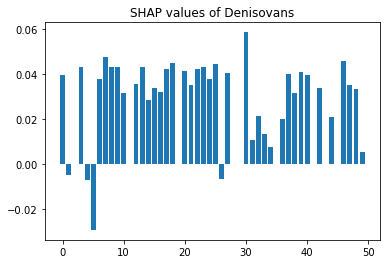